# <span id="chap_er_networks_maths"></span> The mathematics of the ER model

An alternative to simulaton is to analyse a network mathematically, trying to find a closed-form expression for the various properties of interest. We'll focus only on the properties that are most important from a practical perspective: the [Wikipedia page for ER networks](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model) describes, but doesn't derive, lots of other properties (of largely theoretical interest). We'll do this from first principles and at some length, to demonstrate the sorts of mathematical argument that'll be common in what's to come.

## <span id="sec_er_networks_maths_degree_distribution"></span> Degree distribution

We'll start with degree distribution: what is the probability of a node $v$ chosen at random having a given degree $k$? In normal probability notation this would be written $P(deg(v) = k)$, the probability that $deg(v)$, the degree of $v$, is equal to $k$. For brevity we will usually write this as $p_k$. Taken over the whole network, this will yield a degree distribution, where the probability of all possible degrees in the network sum to one: $\sum_k p_k = 1$. So what is the degree distribution for an ER network?

At first acquaintance, many (if not most) non-mathematicians would argue something like this: the probability of including an edge between any pair of nodes is $\phi$, with every edge (and every node) treated equally. Therefore, we'd expect every node to have roughly the same degree as every other &ndash; a degree distribution that's *uniform* &ndash; consistent with the uniformity of the generating process.

Does that sound reasonable? &ndash; it did to me when I first made this argument. But we know from [the simulation we did earlier](er-networks.ipynb#sec_er_networks_degrees) that this *isn't* what happens: we actually get a *normal* distribution of degrees, not a uniform one. (If you need more convincing about this, read the rest of this section and then skip to the [epilogue](#sec_epilogue) at the end of this chapter.) Clearly there's another way of thinking about the process.

Let's re-phrase the question: in an ER network, how does a node end up having degree $k$? We can answer this by looking at the [construction process](er-networks.ipynb#sec_er_networks_building), where we iterated through all the pairs of nodes and added an edge between them with a given, fixed, probability $\phi$ (which we denoted `pEdge` in the code).  So each node *could in principle* have been connected to $N - 1$ other nodes: that's the maximum degree it could have, since we've excluded the possibility of self-loops or parallel edges. For each of these potential edges, we essentially tossed a coin to decide whether the edge was included or not &ndash; except that the "coin" came down "heads" with a probability $\phi$, and therefore came down "tails" with a probability $(1 - \phi)$ (since there are only two alternatives, and their probabilities have to sum to 1). Let's refer to each such decision &ndash; add an edge or don't &ndash; as an *action*. For each node there we perform $N - 1$ actions, one per potential edge, and for a node to have a degree $k$ we have to perform $k$ "add" actions and $(N - 1 - k)$ "don't-add" actions. We can perform these actions in any order.

How many ways are there to perform this sequence of actions? Suppose we have a bag of $a$ actions: how many ways are there to select $b$ actions from the bag? The answer to this is given by the formula $\frac{a!}{b! (a - b)!}$, a result known a the *binomial theorem* and denoted $\binom{a}{b}$.

So, returning to our original question, we have $\binom{N - 1}{k}$ ways to perform $k$ "add" actions from a possible $N - 1$ actions, with the remainder being "don't-add" actions. This is the number of possible sequences that, for a given node, can result in that node having degree $k$. From elementary probability theory, to work out the probability of a sequence of actions happening we multiply-out the probabilities of the individual actions: "this *and* this *and* this" and so forth. So for each sequence of $k$ add actions and $(N - 1 - k)$ don't-add actions we multiply the probailities of each action together to get the probability of them *all* happening, and then multiply this compound probability by number of ways these actions can happen so as to still give us the $k$ edges we want.

Putting all this together, the probability that a node $v$ taken at random from an ER model consisting of $N$ nodes and edge probability $\phi$ will have degree $k$ is given by:

$$p_k = \binom{N - 1}{k} \phi^k (1 - \phi)^{N - 1 - k}$$

That is to say, we need a sequence consisting of $k$ instances of an add action that occurs with probability $\phi$ *and* $(N - 1 - k)$ don't-add actions occurring with probability $1 - \phi$, *and* there are $\binom{N - 1}{k}$ ways in which these actions can be arranged.

This is a distribution well known in statistics as the *binomial distribution*. It's important to note that $\phi$ is a constant, and that each add action is independent of each other add action: it doesn't get any easier to add edges over time. (If this seems like an obvious thing to say, we only say it because this turns out to be different to the approach we'll take to BA networks [later](powerlaw.ipynb).)

Given that we are dealing with large graphs, we will simplify the $N - 1$ term to $N$, since it makes very little difference as $N \rightarrow \infty$, yielding:

$$p_k = \binom{N}{k} \phi^k (1 - \phi)^{N - k}$$

What happens as $N$ gets larger and larger? Clearly $\binom{N}{k}$ also gets larger and larger (there are more and more ways to choose the $k$ edges), and $(1 - \phi)^{N - k}$ gets smaller and smaller (since $1 - \phi$ is by definition less than $1$), while $\phi^k$ stays the same size. It's not blindingly obvious what happens to the equation, but fortunately the answer *is* known: the binomial distribution converges to another distribution, the *Poisson distribution*, as $N \rightarrow \infty$. The Poisson distribution is basically the normal distribution for systems built from discrete events, and is given by:

$$p_k = \frac{(N\phi)^k e^{-N\phi}}{k!}$$

While this form is easier to work with, it's a lot less suggestive. The binomial form is probably to be preferred as a way of thinking about the distribution simply because each of the factors within it relates to a real, concrete phenomenon: add actions, don't-add actions, their probabilities (summing to 1), and the number of ways of combining them.

## <span id="sec_er_networks_maths_mean_degree"></span> Mean degree

A useful number to know for an ER network is the *mean degree*, the degree of an "average" node. A mean degree of $k$ is usually written $\langle k \rangle$.

In [1]:
import networkx as nx
import math
import numpy as np
import numpy.random as rnd

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.cm as cmx
import seaborn

/Users/sd/research/writing/complex-networks-complex-processes/notebook/cncp/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/sd/research/writing/complex-networks-complex-processes/notebook/cncp/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Plotting a Poisson distribution will help understand where the mean degree comes from:

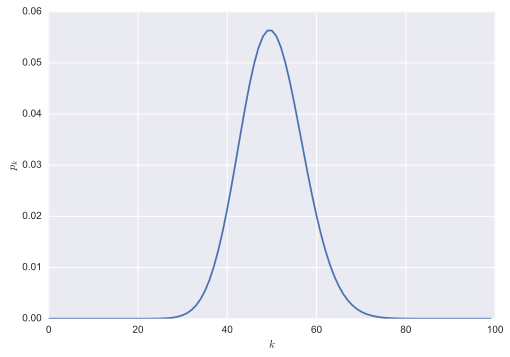

In [2]:
def poisson( n, pEdge ):
    """Return a model function for the Poisson distribution with n nodes and
    edge probability pEdge."""
    def model( k ):
        return (pow(n * pEdge, k) * math.exp(-n * pEdge)) / math.factorial(k)
    return model

fig = plt.figure()
plt.xlabel("$k$")
plt.ylabel("$p_k$")
plt.plot(xrange(100), map(poisson(1000, 0.05), xrange(100)))

_ = plt.show()

The graph is symmetric around the point $x = 50$, suggesting that this is the mean. Looking at the parameters of the distribution, however, we plotted 1000 nodes with an edge probability of 0.05, which multiplied-out also give 50.

In fact the mean of a Poisson distribution is given by $N\phi$. Since the Poisson is an approximation of a binomial for suitably large networks, we can approximate the mean degree of an ER network by $N\phi$: given a number of nodes and an edge probability, we can work out the mean degree. Looking at the equation for the Poisson, we can see that $N$ and $\phi$ are the only parameters: we need to know them, *and only them*, to compute the distribution for any value of $k$. We can therefore say that $N$ and $\phi$ *completely characterise* the distribution.

There is another implication of this, however. Since $\langle k \rangle = N\phi$, we can re-write the probability distribution for at ER network in terms of the network's mean degree:

$$p_k = \frac{\langle k \rangle^k e^{-\langle k \rangle}}{k!}$$

Put another way, we can easily construct a network with a desired mean degree and number of nodes, using these two numbers to derive the necessary edge probability using $\phi = \frac{\langle k \rangle}{N}$.

## <span id="sec_er_networks_maths_moments"></span> Statistical moments

The mean is the simplest example of what is known as a *moment* of a distribution, specifically the *first moment*. Moments try to capture key elements of the "shape" of a distribution. All distributions have a first moment, second moment, and so forth. The idea of a moment is derived from physics, where is relates to the idea of momentum. The first moment of a distribution measures how far an "average" point is from zero. The second moment measures the distance of an "average" point from the mean, and so is an indication of how "spread out" the distribution is.

As with all distributions, the mean degree $\langle k \rangle$ is defined as the *expected value* of the distribution, sometimes written $\mathbb{E}(k)$ and defined by:

\begin{align}
    \mathbb{E}(k) &= 1 \times p_1 + 2 \times p_2 + \cdots \\
                  &= \sum_k k \, p_k
\end{align}

For the Poisson distribution underlying an ER network, we can check that this is approximately the case by working out the expected value for a distribution whose mean we know analytically. If $N = 1000$ and $\phi = 0.05$ then $\langle k \rangle = N\phi = 50$. If we compute this sum for degree up to 100 &ndash; a value well above the mean &ndash; we get:

In [3]:
sum = 0
p = poisson(1000, 0.05)
for k in xrange(1, 100):
    sum = sum + k * p(k)
print sum

49.9999999677


That's a close enough.

Does this number always exist? For an ER network we know from the plot of degree distribution that the probability of having a node with degree $k$ drops-off quickly on either side of the mean. This suggests that the probabilities of high-degree nodes will approach zero, and to the sum for $\mathbb{E}(k)$ will converge. (More rigourously, $\langle k \rangle^k$ grows more slowly than $k!$ and so $p_k \rightarrow 0$ as $k \rightarrow \infty$.)

We can of course calculate the mean degree directly from the observed degrees of the nodes in a network, where

$$
\langle k \rangle = \frac{1}{N} \sum_{i = 1}^{N} \, deg(v_i)
$$

The second moment of the distribution, $\langle k^2 \rangle = \sum_k k^2 \, p_k$, is related to the statistical variance of the degree distribution. More specifically, $\langle k^2 \rangle$ is the *second raw moment*, the variance about zero, while normal statistical usage is to use variance $\sigma^2$ about the mean (the *second central moment*).  We can convert one to the other, since $\sigma^2 = \langle k^2 \rangle - \langle k \rangle^2$. As usual, the (positive) square root of the variance is the *standard deviation* of the distribution.

## <span id="sec_er_networks_maths_diameter"></span> Diameter and characteristic path

Two other summary statistics

...

## <span id="sec_er_networks_maths_components"></span> The critical threshold and the giant component

When we looked at components [earlier](er-networks-components.ipynb), we discovered that a "giant" component forms rapidly as we add edges to the network. The location of this critical threshold can be determined analytically, removing the need for simulation. How this is done is another useful illustration of mathematical reasoning applied to networks.

Suppose we have a network with $N$ nodes and edge probability $\phi$, and suppose further that this network has a giant component. How does a node $i$ come to *not* be in the giant component? This happens when $i$ is not adjacent to a node that *is* in the giant component. That means that, for every other node $j$ in the network, either:

* $i$ is not linked to $j$; or
* $i$ is linked to $j$, but $j$ is also not in the giant component

Let $u$ denote the fraction of nodes that are not in the giant component. In an ER network, this means that $u$ is also the probability that a node chosen at random is not in the giant component. We can use $u$ to capture the two cases above. The probability that $i$ is not adjacent to $j$ is simply $1 - \phi$, the probability of not having made an edge between $i$ and $j$. The probability that a node $j$ adjacent to $i$ is not in the giant component is $\phi u$, the probability of there being ad edge between $i$ and $j$ *and* that $j$ is not in the giant component. Therefore the total probability of a random node $i$ not being in the giant component is given by the sum of these two probabilities, $1 - \phi + \phi u$. We know that $i$ has $N - 1$ other nodes to connect to, or approximately $N$ in the limit of a large network, so we find the probability of a node $i$ not being in the giant component as:

\begin{align*}
    u &= (1 - \phi + \phi u)^N \\
      &= (1 - \phi(1 - u))^N \\
      &= \bigg ( 1 - \frac{\langle k \rangle}{N} (1 - u) \bigg )^N
\end{align*}

(making use of $\phi = \frac{\langle k \rangle}{N}$ from [above](#sec_er_mean_degree_maths)). Notice that $u$ appears on both sides of the equation. If we take logs we get:

\begin{align*}
    \log u &= N \log \bigg ( 1 - \frac{\langle k \rangle}{N} (1 - u) \bigg ) \\
           &= -N \frac{\langle k \rangle}{N} (1 - u) \\
           &= -\langle k \rangle(1 - u)
\end{align*}

and so:

$$
    u = e^{-\langle k \rangle(1 - u)}
$$

It's perhaps awkward to reason in terms of the fraction of nodes *not in* the giant component, so if we denote the fraction of nodes that *are in* the giant component by $S = 1 - u$ then we can re-arrange this expression to get:

$$
    S = 1 - e^{-\langle k \rangle S}
$$

Again we have $S$ on both side. If we re-arrange to solve for $\langle k \rangle$, we get:

\begin{align*}
                S - 1 &= - e^{-\langle k \rangle S} \\
                1 - S &= e^{-\langle k \rangle S} \\
         \log (1 - S) &= -\langle k \rangle S \\
    \langle k \rangle &= - \frac{\log (1 - S)}{S}
\end{align*}

What does all this mean? To find solutions for $S$, the fractional size of the giant component for different mean degrees,  we have to fall back on graphical means, plotting $y = 1 - e^{-\langle k \rangle S}$ for different values of $\langle k \rangle$. The solutions are then where these curves meets the line $y = S$. We show this in the left-hand plot below. In the right-hand plot we  show the size of the giant component for different values of $\langle k \rangle$.

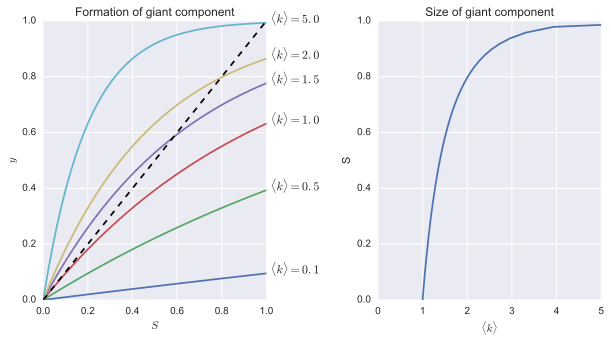

In [4]:
# y = 1 - e^{<k> S} for some parameter <k>
def make_er_giant_component_fraction( kmean ):
    def model( S ):
        return 1 - math.exp(-kmean * S)
    return model

# y = log(1 - S) / S
def er_giant_component_degree( S ):
    return -(math.log(1 - S) / S)

# plot along the closed interval (0, 1)
ss = np.linspace(0.001, 0.999)

# create a figure with two side-by-side sub-plots
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
plt.subplots_adjust(wspace = .5)                   # a bit more space between sub-plots

# plot the formation of the giant component
ax[0].set_title('Formation of giant component')
ax[0].set_xlabel('$S$')
ax[0].set_ylabel('$y$')

# plot the fraction S for some different values of <k>
for kmean in [0.1, 0.5, 1.0, 1.5, 2.0, 5.0]:
    gcf = make_er_giant_component_fraction(kmean)
    _ = ax[0].plot(ss, map(gcf, ss))
    
    # label each curve off to the right of the graph axes,
    # at the same height as the end of the curve
    ax[0].text(1.02, gcf(0.999), '$\\langle k \\rangle = ' + str(kmean) + '$')

# add the solution line y = S
ax[0].plot([0, 1], [0, 1], 'k--', label = '$y = S$')

# plot the fraction S of the giant component as a function of <k>
ax[1].set_xlim([0, 5])
ax[1].set_title('Size of giant component')
ax[1].set_xlabel('$\\langle k \\rangle$')
ax[1].set_ylabel('S')
_ = ax[1].plot(map(er_giant_component_degree, ss), ss)

There are two messages from these graphs. On the left-hand side, different values of $\langle k \rangle$ give different size of giant component. The curve for $\langle k \rangle = 2$, for example, results in $S = 0.8$: the giant component will occupy four-fifths of the nodes. For $\langle k \rangle < 1$, no giant component will form at all. On the right-hand side, the size of the giant component asymptotically approaches 1 as $\langle k \rangle$ increases.

We should check these results experimentally, just to be sure:

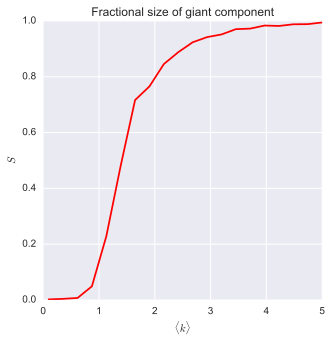

In [5]:
def make_er_giant_component_size_by_kmean( n ):
    """Return a model function for a network with the given number
    of nodes, computing the fractional size of the giant component
    for different mean degrees."""
    def model( kmean ):
        phi = kmean / n
        er = nx.erdos_renyi_graph(n, phi)
        gc = len(max(nx.connected_components(er), key = len))
        S = (gc + 0.0) / n
        return S
    return model

fig = plt.figure(figsize = (5, 5))
plt.title('Fractional size of giant component')
plt.xlabel('$\\langle k \\rangle$')
plt.ylabel('$S$')
kmeans = np.linspace(0.1, 5.0, num = 20)
_ = plt.plot(kmeans, map(make_er_giant_component_size_by_kmean(2000), kmeans), 'r-')

You'll notice this curve doesn't exactly follow what the analytical solution would suggest: we seem to get take-off slightly before $\langle k \rangle = 1$, and the curve isn't smooth. The analytical model is expressed in terms of averages, while the graph above is generated from *one specific* ER network that *might* happen to have properties that cause a giant component to form, or not form, or form with a slightly different size than predicted, just becase of some fluke of the edges. The mathematical expression gives us the expected behaviour that's overwhemingly probable in the case of large ($N \rightarrow \infty$) networks but can be misleading in smaller networks.  

## <span id="sec_er_networks_maths_excess_degree"></span> Excess degree

Suppose we select a node at random, then select an edge at random, and traverse it: what would we expect the degree of the node we arrive at to be? The obvious answer might be $\langle k \rangle$: is that correct? Put another way, what is the degree distribution of neighbours of a node? 

A randomly-selected node in an ER network will be expected to have degree $\langle k \rangle$, by definition, However &ndash; perhaps surprisingly &ndash; this doesn't imply that a *neighbouring node selected at random* will also have degree $\langle k \rangle$. Nodes with high degree are easier to reach than other nodes &ndash; they have more incident edges &ndash; so a neigbouring node is somewhat more likely to have higher degree than normal. We'll explore this mathematically and then computationally.

In almost all the networks we'll consider in this book, we disallow parallel edges (two edges with the same endpoints) and self-loops (edges that start and end on the same node). This means that each edge is incident on two, different, nodes, and that each edge contributes to the degree of these two nodes. This implies that, if there are $M$ edges in the network, $\sum_v deg(v) = 2M$. Suppose we choose a random node $v$ and a random edge $e$ leaving $v$. There are $2M - 1$ places that the other end of $e$ can attach to in the network, and $k$ of them are on a *particular* node of degree $k$, so the probability of $e$ being attached to a *particular* node of degree $k$ is $\frac{k}{2M - 1} \approx \frac{k}{2M}$. Given that there are $N \, p_k$ nodes of degree $k$ in the network, the probability of $e$ attaching to *any* node of degree $k$ is given by:

$$
\frac{k}{2M} N \, p_k = \frac{N}{2M} k \, p_k
$$

However, it is also the case that $2M = N \langle k \rangle$ &ndash; there are $N$ times the mean degree of attachment points for edges. Therefore the probability that a randomly-chosen node is adjacent to a node of degree $k$ is given by

$$
\frac{k \, p_k}{\langle k \rangle}
$$

Put another way, the probability of reaching a node of degree $k$ is proportional to $k \, p_k$, not simply proportional to the frequency of nodes of degree $k$ is in the network as a whole, to compensate for the fact that higher-degree nodes are adjacent to relatively more nodes than lower-degree nodes. 

What, then is the average degree of the neighbour of a randomly-chosen node? We can get this by multiplying out the probabilities for all values of $k$, giving:

\begin{align*}
    \sum_k k \frac{k \, p_k}{\langle k \rangle}
    &= \frac{\sum_k k^2 \, p_k}{\langle k \rangle} \\
    &= \frac{\langle k^2 \rangle}{\langle k \rangle}
\end{align*}

(Using the definition of the second moment from earlier.) This leads to the surprising conclusion that the average degree of the neighbour of a randomly-chosen node is not the same as that of a randomly-chosen node itself. In fact we can express it simply in terms of the variance from above:

\begin{align*}
    \frac{\langle k^2 \rangle}{\langle k \rangle} - \langle k \rangle
    &= \frac{1}{\langle k \rangle} ({\langle k^2 \rangle} - {\langle k \rangle^2}) \\
    &= \frac{\sigma^2}{\langle k \rangle}
\end{align*}

Since $\langle k \rangle$ is always positive, and since $\sigma^2$ is always non-negative (and strictly greater than zero if there is any variation at all in the degrees of nodes), this implies that $\frac{\langle k^2 \rangle}{\langle k \rangle} > {\langle k \rangle}$.

The number of edges attached to a neighbouring node excluding the edge we traversed to get there (*i.e.*i, the one that makes it adjacent in the first place) is referred to as the *excess degree* of the node, and is by definition one less than the degree of the neighbouring node. If we denote the probability of a node having excess degree $k$ by $q_k$, we can then define the probability distribution of excess degree in the network, which is the same as a node having degree $k + 1$, which is simply:

$$
q_k = \frac{(k + 1) \, p_k}{\langle k \rangle}
$$

using the probability we derived above. To be clear: $p_k$ is the probability of a node selected at random having degree $k$; $q_k$ is the probability of a neighbouring node having *excess* degree $k$ (degree $k + 1$).

In random graphs like the ER network, $q_k$ is uncorrelated with the degree of the initial node chosen. This often isn't true for real-world networks, where it may be the case that, for example, high-degree nodes have neighbours that are themselves more likely to be high-degree. In that case, $q_k$ would be correlated with the degree of the initial node, and the computation would have to reflect this correlation. It is important to remember that a lot of the simplifications we have made above, using mean degrees and second moments, rely on the underlying randomness &ndash; that is to say, un-correlatedness &ndash; of the node degrees, and if these assumptions aren't met the calculations will yield the wrong results.

## <span id="sec_er_networks_maths_summary"></span> Summary

In this chapter we've looked at two approaches to complex network modelling: using simulation within `NetworkX`, and mathematically using the Poisson distribution and mean degree. These two approaches are complementary, and it's important to understand both so they can be used appropriately. Also, the approaches used for the ER network are pretty much standard for other, more complex networks that have richer structures.

## <span id="sec_er_networks_maths_epilogue"></span> Epilogue: why *isn't* the degree distribution uniform?

Earlier we asserted that many people, on first seeing the generating process for the ER model, assume that it will result in a uniform degree distribution. I certainly did. Since it's such a common reaction, it's perhaps worth exploring a little why it's also wrong.

The argument for a uniform degree distribution goes roughly as follows: since the edge probability is independent for every edge, we'd expect that, at each node, we select roughly the same number of edges to add, and therefore there's no reason for one node to be preferred over another, so they should all have roughly the same degree.

The problem here is that it takes a statement about *edges* and subtly converts it into a statement about *nodes*. Just because we select edges with a constant probability doesn't imply that we do so uniformly at the node level &ndash; so uniformly, in fact, that every node ends up having *exactly* the same number of edges. Put that way, a uniform degree distribution actually sounds rather unlikely! The process only says that, *over the graph as a whole*, edges are added with constant probability: it does not say anything about the *local* behaviour of edge addition around an individual node. It is this that allows for the possibility of non-uniform distrbution.

This observation &ndash; that global behaviour, and typically global regularity, doesn't lead to local regularity &ndash; is perhaps the single most important thing to bear in mind about complex networks. It's tempting to think that large-scale regularity emerges from lots of small-scale regularity, but that isn't necessarily the case: the small scale could be irregular, but the irregularities could even out. Conversely, it's tempting to think that something that looks regular and well-behaved on the outside has component pieces that are regular and well-behaved &ndash; and again that isn't necessarily the case. The lesson here is that things can be more complex than they seem. On the other hand, it also means that we can often ignore local noise and make use of global properties, as long as we're careful.

The description we used for the ER generator is an example of a process that in mathematics is called a [Bernoulli process](https://en.wikipedia.org/wiki/Bernoulli_process), where we look at the sequence of actions needed to generate a given outcome and compute how many ways there are for those actions to occur at random. Bernoulli processes occur whenever we encounter actions being performed one after the other according to some random driver, and the [argument above](#sec_er_degree_distribution) is completely typical of how one deals with them.